## Итоговый проект:
# "Big Data: основы работы с большими массивами данных"

### Работаем с набором данных [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/)

**Необходимые файлы:**
- u.data
- u.genre
- u.info
- u.item
- u.occupation
- u.user

In [184]:
import numpy as np
import pandas as pd
import statistics
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## 1. Загрузить данные в pandas

In [2]:
df_data = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.data", sep='\t', header=None)
df_genre = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.genre", sep='|', header=None)
df_info = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.info", sep=' ', header=None)
df_item = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.item", sep='|', encoding='latin_1', header=None)
df_occupation = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.occupation", sep=' ', header=None)
df_user = pd.read_csv("/Users/aleksandr/Desktop/big_data/u.user", sep='|', header=None)

**Дадим корректные названия колонкам в каждом из файлов**

In [3]:
df_data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df_genre.columns = ['genres', 'genres_id']
df_occupation.columns = ['occupation']
df_user.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
df_item.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 
                   'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 
                   'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                   'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                   'War', 'Western']

**Выводы по данным:**

- в некоторых файлах происходит дубликация данных, таких как u.user и u.occupation
    - u.occupation в дальнейшем не будет учавствовать в анализе т.к. необходимая для нас информация есть в u.user
    
    
- в файле u.info суммарная информация по колличесту пользователей, предметов, оценках
    - u.info в дальнейшем не будет учавствовать в анализе т.к. файл несет чисто информационных характер
    
    
- из наблюдения по содержанию файла u.item и u.data столбец movie_id = item_id
    - в u.data вместо колонки item_id сразу переименую ее в movie_id для дальнейшей склейки данных


- по файлу u.genre пока трудно сказать необходим ли он нам в дальнейшем т.к. информация о жанре присутствует в u.item и она более полезна потому что в фильме может присутствать не только один жанр


***Можно формировать единый dataset для последующего анализа***

In [4]:
d1 = pd.merge(df_data, df_user, on='user_id', how='inner')
data = pd.merge(d1, df_item, on='movie_id', how='inner')

In [5]:
data.sample(5)

,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,movie_title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
35655,887,673,5,881381382,14,F,student,27249,Cape Fear (1962),01-Jan-1962,...,0,1,0,0,0,0,0,1,0,0
60945,198,143,3,884208951,21,F,student,55414,"Sound of Music, The (1965)",01-Jan-1965,...,0,0,0,1,0,0,0,0,0,0
17912,136,298,4,882693569,51,M,other,97365,Face/Off (1997),27-Jun-1997,...,0,0,0,0,0,0,1,1,0,0
41947,345,69,4,884992755,28,F,librarian,94143,Forrest Gump (1994),01-Jan-1994,...,0,0,0,0,0,1,0,0,1,0
36160,940,310,3,884800966,32,M,administrator,02215,"Rainmaker, The (1997)",01-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


**Получаем объедененный dataset "data" для последующей работы, изучим его более подробнее**

In [6]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'age', 'gender',
       'occupation', 'zip_code', 'movie_title', 'release_date',
       'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

**Разберемся с названием колонок, чтобы понимать содержимое нашего dataset:**
- 'user_id' - id пользователя
- 'movie_id' - id фильма
- 'rating'- рейтинг оставленный пользователем фильму
- 'timestamp' - дата когда пользователь оставил отзыв
- 'age' - возраст пользователя
- 'gender' - пол пользователя
- 'occupation' - профессия пользователя
- 'zip_code' - почтовый индекс пользователя
- 'movie_title' - название фильма
- 'release_date' - дата выхода фильма
- 'video_release_date' - дата выхода фильма (тут нужно изучить подробнее)
- 'IMDb_URL' - ссылка на рейтинг IMDb к фильму
- 'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' - жанры фильмов

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 31 columns):
user_id               100000 non-null int64
movie_id              100000 non-null int64
rating                100000 non-null int64
timestamp             100000 non-null int64
age                   100000 non-null int64
gender                100000 non-null object
occupation            100000 non-null object
zip_code              100000 non-null object
movie_title           100000 non-null object
release_date          99991 non-null object
video_release_date    0 non-null float64
IMDb_URL              99987 non-null object
unknown               100000 non-null int64
Action                100000 non-null int64
Adventure             100000 non-null int64
Animation             100000 non-null int64
Children's            100000 non-null int64
Comedy                100000 non-null int64
Crime                 100000 non-null int64
Documentary           100000 non-null int64
Drama    

**Посмотрим на выбросы в данных**

,Total,Percent
video_release_date,100000,100.000
IMDb_URL,13,0.013
release_date,9,0.009


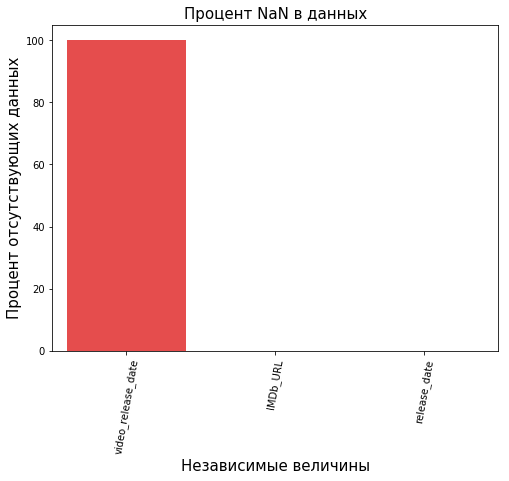

In [8]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

missingdata(data)

**Вывод:**
- по info у нас довольно много переменных, но насколько эти переменные имеют значение? Некоторые переменные можно исключить
- необходимо убрать выбросы из нашего dataset

In [9]:
drop_column = ['video_release_date', 'IMDb_URL', 'zip_code', 'release_date']
data_d1 = data.drop(drop_column, axis=1)

In [10]:
data_d1.head()

,user_id,movie_id,rating,timestamp,age,gender,occupation,movie_title,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,Kolya (1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,Kolya (1996),0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,Kolya (1996),0,0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,Kolya (1996),0,0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,Kolya (1996),0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
display(data_d1.isnull().sum())
print('Итого выбросов данных: {}'.format(data_d1.isnull().sum().sum()))

user_id        0
movie_id       0
rating         0
timestamp      0
age            0
gender         0
occupation     0
movie_title    0
unknown        0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
sex            0
dtype: int64

Итого выбросов данных: 0


**Выбросов нет, поменяем поле 'gender' на числовое**

In [12]:
data_d1['sex'] = data_d1['gender']
data_d1.loc[data_d1['gender'] == 'F', 'sex'] = 0
data_d1.loc[data_d1['gender'] == 'M', 'sex'] = 1

data_d2 = data_d1.drop(['gender'], axis = 1)
df = data_d2[['user_id', 'movie_id', 'rating', 'timestamp', 'age', 'sex', 'occupation',
       'movie_title', 'unknown', 'Action', 'Adventure', 'Animation',
       "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western']]

In [13]:
df.sample(5)

,user_id,movie_id,rating,timestamp,age,sex,occupation,movie_title,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
7767,381,588,3,892697338,33,1,artist,Beauty and the Beast (1991),0,0,...,0,0,0,1,0,0,0,0,0,0
26245,396,871,2,884646289,57,1,engineer,Vegas Vacation (1997),0,0,...,0,0,0,0,0,0,0,0,0,0
89643,574,319,5,891279236,56,1,educator,Everyone Says I Love You (1996),0,0,...,0,0,0,1,0,1,0,0,0,0
20535,363,80,4,891498434,20,1,student,Hot Shots! Part Deux (1993),0,1,...,0,0,0,0,0,0,0,0,1,0
73815,588,729,3,890024488,18,0,student,Nell (1994),0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Посчитайте среднюю оценку, которую поставил каждый пользователь

In [163]:
# umr = df.groupby(['user_id', 'movie_id']).mean()[['rating']]
# umr.style.bar()

**Список пользователей достаточно большой, чтобы выводить всех на экран, давате посмотрим топ:**
- топ 5 по средней самым высоким оценкам оставленных пользователями
- топ 5 по средней самым низким оценкам оставленных пользователями

***umr_mean*** - посмотреть оценки по всем пользователям, сортировка от большего к меньшему

***umr*** - посмотреть оценки пользователей в разрезе фильмов

In [77]:
umr_mean = df.groupby('user_id').mean()[['rating']].sort_values('rating', ascending=False).reset_index()
# umr_mean.head()

print("Топ 5 пользователей, которые ставили самые высокие оценки за все время:")
display(umr_mean[:5])

print("\nТоп 5 пользователей, которые ставили самые низкие оценки за все время:")
display(umr_mean[-5:].sort_values('rating', ascending=True))

Топ 5 пользователей, которые ставили самые высокие оценки за все время:


,user_id,rating
0,849,4.869565
1,688,4.833333
2,507,4.724138
3,628,4.703704
4,928,4.687500



Топ 5 пользователей, которые ставили самые низкие оценки за все время:


,user_id,rating
942,181,1.491954
941,405,1.834464
940,445,1.985185
939,685,2.050000
938,774,2.058036


**Итого:**
- Пользователь с ID 849, поставил в среднем оценки приближенные к максимальному баллу
- Пользователь с ID 181, поставил в среднем оценки приближенные к минимальному баллу

## 3. Отсортируйте фильмы по количеству оценок

**Список фильмов достаточно большой, чтобы выводить все полученные данные на экран, давате посмотрим топ:**
- топ 10 фильмов по колличеству оставленных оценок

***fmr_count*** - посмотреть колличество оценкок по всем фильмам, сортировка от большего к меньшему

In [94]:
fmr_count = df['movie_id'].value_counts().to_frame().reset_index()
# fmr_count['percent'] = fmr_count["movie_id"].apply(lambda x : round(100*float(x) / len(fmr_count), 2))
fmr_count = fmr_count.rename(columns = {"index" : "movie_id", "movie_id" : "count"})
fmr_count.head(10)

,movie_id,count
0,50,583
1,258,509
2,100,508
3,181,507
4,294,485
5,286,481
6,288,478
7,1,452
8,300,431
9,121,429


**Итого:**
- фильм **Star Wars (1977)** с id 50 имеет самый высокий показатель по оставленным оценкам

## 4. Средствами pandas соедините данные по оценкам с данными по пользователям

In [86]:
df.sample(5)

,user_id,movie_id,rating,timestamp,age,sex,occupation,movie_title,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
95830,399,39,2,882344310,25,1,other,Strange Days (1995),0,1,...,0,0,0,0,0,0,1,0,0,0
53422,128,924,3,879967341,24,0,marketing,White Squall (1996),0,0,...,0,0,0,0,0,0,0,0,0,0
20529,1,80,4,876893008,24,1,technician,Hot Shots! Part Deux (1993),0,1,...,0,0,0,0,0,0,0,0,1,0
42398,345,365,2,884993760,28,0,librarian,Powder (1995),0,0,...,0,0,0,0,0,0,0,0,0,0
81197,58,1105,2,884794758,27,1,programmer,Firestorm (1998),0,1,...,0,0,0,0,0,0,0,1,0,0


## 5. Построить модель, которая предсказывает оценку для фильма от пользователя (воспользоваться RandomForestRegressor, т.к. мы решаем задачу регрессии)

In [97]:
# corr_df_p = df.corr(method='pearson')
# corr_df_p

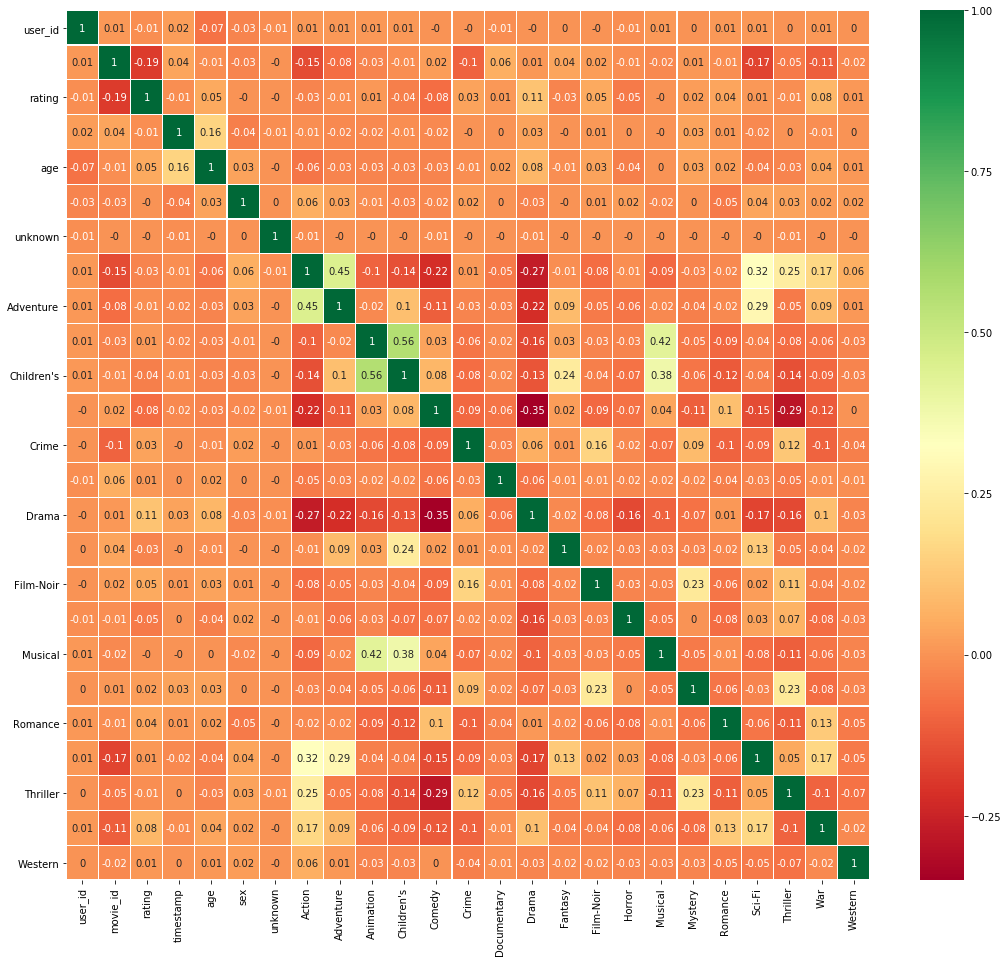

In [95]:
correlation_matrix = df.corr(method ='pearson').round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(18,16)
plt.show()

In [137]:
df_occupation['occupation_id'] = pd.factorize(df_occupation.occupation)[0] + 1
df_t = pd.merge(df, df_occupation, on='occupation', how='inner')

df_Xy = df_t[['user_id', 'movie_id', 'rating', 'timestamp', 'age', 'sex',
       'occupation_id', 'unknown', 'Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']]

In [138]:
df_Xy.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'age', 'sex',
       'occupation_id', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='object')

In [173]:
X = df_Xy[['user_id', 'movie_id', 'age', 'sex',
       'occupation_id', 'unknown', 'Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']]
y = df_Xy['rating']

In [174]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [175]:
print('Number of observations in the training data:', len(X_train))
print('Number of observations in the test data:',len(X_test))

Number of observations in the training data: 70000
Number of observations in the test data: 30000


In [176]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [177]:
y_pred = classifier.predict(X_test)
y_pred

array([5, 3, 1, ..., 3, 5, 4])

## 6. Оценить качество регрессора на отложенной (train_test_split) 

In [192]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.3435666666666667

In [191]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3491

In [179]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.30      0.24      0.26      1876
           2       0.20      0.17      0.18      3460
           3       0.33      0.36      0.35      8167
           4       0.38      0.43      0.41     10163
           5       0.37      0.31      0.34      6334

   micro avg       0.34      0.34      0.34     30000
   macro avg       0.32      0.30      0.31     30000
weighted avg       0.34      0.34      0.34     30000



**Качество модели 34%, что довольно низкий показатель**

In [ ]:
pass

Продолжение работы в **dep_bd_2_spark**